# Data Processing

In [1]:
# !pip install keras_applications

In [2]:
import numpy as np
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
import cv2
warnings.filterwarnings("ignore")
from numpy.random import permutation
np.random.seed(2016)
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPool2D # GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras import utils
from keras.models import model_from_json
from sklearn.metrics import log_loss, confusion_matrix
from keras import regularizers
import h5py

from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
# from keras.layers.advanced_activations import LeakyReLU
from sklearn.metrics import confusion_matrix

from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, \
    GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Conv2D
from keras.models import Model
# from keras.engine.topology import get_source_inputs
from keras.losses import CategoricalCrossentropy
from keras.utils import get_source_inputs, plot_model
# from depthwise_conv2d import DepthwiseConvolution2D

/home/amirhossein_sr/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-04-13 19:13:58.984118: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-13 19:13:59.031572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-13 19:13:59.031617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cu

In [3]:
use_cache = 1
dataset_path = r'../Dataset/v2_cam1_cam2'

np.random.seed(1234)
warnings.filterwarnings("ignore")

In [4]:
def get_im_cv2(path):
    img = cv2.imread(path)
    resized = cv2.resize(src=img, dsize=(224, 224), interpolation=cv2.INTER_LINEAR) / 255.0
    return resized

In [5]:
def load_train(num_classes=10):
    train_dir_cam1 = dataset_path + '/Camera 1/train/'
    train_dir_cam2 = dataset_path + '/Camera 2/train/'

    X_train = []
    Y_train = []

    print('Read train images')

    for label in range(num_classes):
        class_label = 'c' + str(label)  # Example: c0
        class_dir_cam1 = train_dir_cam1 + class_label
        class_dir_cam2 = train_dir_cam2 + class_label

        x1 = os.listdir(class_dir_cam1)
        x2 = os.listdir(class_dir_cam2)

        for i in range (0,len(x1)):
            print(f"Reading image {x1[i]} of camera 1 - class {class_label}: {i}/{len(x1)}")
            img = get_im_cv2(class_dir_cam1 + '/' + x1[i])
            X_train.append(img)
            Y_train.append(label)
            # if i == 5: break

        for i in range (0,len(x2)):
            print(f"Reading image of camera 2 - class {class_label}: {i}/{len(x2)}")
            img = get_im_cv2(class_dir_cam2 + '/' + x2[i])
            X_train.append(img)
            Y_train.append(label)


    return X_train, Y_train

In [6]:
def load_valid(num_classes=10):
    test_dir_cam1 = dataset_path + '/Camera 1/test/'
    test_dir_cam2 = dataset_path + '/Camera 2/test/'

    X_valid = []
    Y_valid = []

    print('Read test images')

    for label in range(num_classes):
        class_label = 'c' + str(label)  # Example: c0
        class_dir_cam1 = test_dir_cam1 + class_label
        class_dir_cam2 = test_dir_cam2 + class_label

        x1 = os.listdir(class_dir_cam1)
        x2 = os.listdir(class_dir_cam2)

        for i in range (0,len(x1)):
            print(f"Reading image {x1[i]} of camera 1 - class {class_label}: {i}/{len(x1)}")
            img = get_im_cv2(class_dir_cam1 + '/' + x1[i])
            X_valid.append(img)
            Y_valid.append(label)

        for i in range (0,len(x2)):
            print(f"Reading image of camera 2 - class {class_label}: {i}/{len(x2)}")
            img = get_im_cv2(class_dir_cam2 + '/' + x2[i])
            X_valid.append(img)
            Y_valid.append(label)

    return X_valid, Y_valid

In [7]:
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')

In [8]:
def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

In [9]:
def read_and_normalize_train_data():
    cache_path = dataset_path + '/cache/train_v12.dat'
    if not os.path.isfile(cache_path) or use_cache == 0:
        train_data, train_target= load_train()
        cache_data((train_data, train_target), cache_path)
    else:
        print('Restore train from cache!')
        (train_data, train_target) = restore_data(cache_path)
    
    print('Convert to numpy...')
    train_data = np.array(train_data, dtype=np.float16)
    train_target = np.array(train_target, dtype=np.uint8)
    
    print('Reshape...')
    train_data = train_data.transpose((0, 1, 2, 3))

    # Normalise the train data
    print('Convert to float...')
    train_data = train_data.astype('float16')
    # mean_pixel = [80.857, 81.106, 82.928]
    mean_pixel = np.mean(np.mean(train_data, axis=(1, 2)), axis=0)
    print(mean_pixel)
    
    print('Substract 0...')
    train_data[:, :, :, 0] -= mean_pixel[0]
    
    print('Substract 1...')
    train_data[:, :, :, 1] -= mean_pixel[1]

    print('Substract 2...')
    train_data[:, :, :, 2] -= mean_pixel[2]

    train_target = utils.to_categorical(train_target, 10)
    
    # Shuffle experiment START !!
    perm = permutation(len(train_target))
    train_data = train_data[perm]
    train_target = train_target[perm]
    # Shuffle experiment END !!
    
    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    print('Target shape:', train_target.shape)
    print(train_target.shape[0], 'target samples')
    return train_data, train_target

In [10]:
def read_and_normalize_test_data():
    start_time = time.time()
    cache_path = dataset_path + '/cache/test_v12.dat'

    if not os.path.isfile(cache_path) or use_cache == 0:
        test_data, test_target = load_valid()
        cache_data((test_data, test_target ), cache_path)
    else:
        print('Restore test from cache [{}]!')
        (test_data, test_target) = restore_data(cache_path)

    test_data = np.array(test_data, dtype=np.float16)
    test_data = test_data.transpose((0, 1, 2, 3))

    # Normalise the test data data

    test_data = test_data.astype('float16')
    mean_pixel = np.mean(np.mean(test_data, axis=(1, 2)), axis=0)

    test_data[:, :, :, 0] -= mean_pixel[0]

    test_data[:, :, :, 1] -= mean_pixel[1]

    test_data[:, :, :, 2] -= mean_pixel[2]

    test_target = utils.to_categorical(test_target, 10)
    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    print('Target shape:', test_target.shape)
    print(test_target.shape[0], 'target samples')
    print('Read and process test data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return test_data, test_target

In [11]:
X_train, Y_train = read_and_normalize_train_data()
X_valid, Y_valid = read_and_normalize_test_data()

Restore train from cache!
Convert to numpy...
Reshape...
Convert to float...
[0.3167 0.3176 0.3247]
Substract 0...
Substract 1...
Substract 2...
Train shape: (14978, 224, 224, 3)
14978 train samples
Target shape: (14978, 10)
14978 target samples
Restore test from cache [{}]!
Test shape: (2330, 224, 224, 3)
2330 test samples
Target shape: (2330, 10)
2330 target samples
Read and process test data time: 9.97 seconds


# Model Execution

In [ ]:
batch_size = 64
nb_epoch = 250

In [ ]:
def VGG_16(input_shape=(224,224,3), classes=10):

    img_input = Input(shape =input_shape)
    print(img_input)

    # 1st Conv Block

    x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(img_input)
    x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

    # 2nd Conv Block

    x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

    # 3rd Conv block

    x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    x = Dropout(0.1)(x)
 
    # 4th Conv block

    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    x = Dropout(0.2)(x)

    # 5th Conv block

    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
    x= Dropout(0.3)(x)

    # Last block

    x = Conv2D (filters =512, kernel_size =7, padding ='same', activation='relu')(x)
    x= Dropout(0.4)(x)
    x = Conv2D (filters =512, kernel_size =1, padding ='same', activation='relu')(x)
    x= Dropout(0.5)(x)
    x = Conv2D (filters =classes, kernel_size =1, padding ='same', activation='softmax')(x)
    output = GlobalAveragePooling2D()(x)

    # creating the model

    model = Model (inputs=img_input, outputs =output, name='VGG_16')
    model.summary()    

    # model.load_weights('weights.h5')
    opt = SGD(learning_rate=0.0001, momentum=0.9, weight_decay=10e-6)

    model.compile(opt, loss=CategoricalCrossentropy(), metrics=['accuracy'])
    return model

In [ ]:
model = VGG_16()

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


2024-04-13 12:44:59.247044: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20966 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-04-13 12:44:59.247808: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22493 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:65:00.0, compute capability: 8.6


Model: "VGG_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
weights_path=r'./Checkpoint/'       
callbacks = [ModelCheckpoint(weights_path, monitor='val_acc', save_best_only=True, verbose=1)]

print(X_train.shape)
hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_valid, Y_valid), use_multiprocessing=True, workers=16)

(12977, 224, 224, 3)
Epoch 1/250


2024-04-13 12:45:16.609742: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inVGG_16/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-13 12:45:17.108484: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-13 12:45:17.245512: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-13 12:45:20.045300: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-13 12:45:22.370201: I external/local_xla/xla/service/service.cc:168] XLA service 0x7cc241c68910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-13 12:45:22.370242: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute

136/136 [==============================] - 121s 631ms/step - loss: 2.2279 - accuracy: 0.2063 - val_loss: 2.2232 - val_accuracy: 0.2129
Epoch 2/250
136/136 [==============================] - 73s 541ms/step - loss: 2.2164 - accuracy: 0.2130 - val_loss: 2.2220 - val_accuracy: 0.2129
Epoch 3/250
136/136 [==============================] - 74s 542ms/step - loss: 2.2149 - accuracy: 0.2130 - val_loss: 2.2148 - val_accuracy: 0.2129
Epoch 4/250
136/136 [==============================] - 73s 534ms/step - loss: 2.2145 - accuracy: 0.2130 - val_loss: 2.2227 - val_accuracy: 0.2129
Epoch 5/250
 59/136 [============>.................] - ETA: 36s - loss: 2.2047 - accuracy: 0.2198

2024-04-13 12:51:24.570436: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


136/136 [==============================] - 73s 534ms/step - loss: 2.2119 - accuracy: 0.2129 - val_loss: 2.2176 - val_accuracy: 0.2129
Epoch 6/250
136/136 [==============================] - 73s 534ms/step - loss: 2.2114 - accuracy: 0.2129 - val_loss: 2.2194 - val_accuracy: 0.2097
Epoch 7/250
136/136 [==============================] - 72s 528ms/step - loss: 2.2091 - accuracy: 0.2128 - val_loss: 2.2170 - val_accuracy: 0.2129
Epoch 8/250
136/136 [==============================] - 71s 526ms/step - loss: 2.2074 - accuracy: 0.2132 - val_loss: 2.2138 - val_accuracy: 0.2147
Epoch 9/250
136/136 [==============================] - 71s 524ms/step - loss: 2.2054 - accuracy: 0.2127 - val_loss: 2.2064 - val_accuracy: 0.2057
Epoch 10/250
136/136 [==============================] - 72s 528ms/step - loss: 2.2025 - accuracy: 0.2137 - val_loss: 2.2063 - val_accuracy: 0.2094
Epoch 11/250
136/136 [==============================] - 72s 528ms/step - loss: 2.1989 - accuracy: 0.2187 - val_loss: 2.2006 - val_accur

2024-04-13 13:18:02.722644: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


136/136 [==============================] - 73s 537ms/step - loss: 1.7925 - accuracy: 0.3514 - val_loss: 1.7257 - val_accuracy: 0.3607
Epoch 28/250
136/136 [==============================] - 73s 537ms/step - loss: 1.7737 - accuracy: 0.3526 - val_loss: 1.6910 - val_accuracy: 0.3856
Epoch 29/250
136/136 [==============================] - 73s 535ms/step - loss: 1.7608 - accuracy: 0.3697 - val_loss: 1.6863 - val_accuracy: 0.3766
Epoch 30/250
136/136 [==============================] - 73s 535ms/step - loss: 1.7248 - accuracy: 0.3789 - val_loss: 1.6304 - val_accuracy: 0.3981
Epoch 31/250
136/136 [==============================] - 73s 534ms/step - loss: 1.7089 - accuracy: 0.3830 - val_loss: 1.6033 - val_accuracy: 0.4061
Epoch 32/250
136/136 [==============================] - 72s 529ms/step - loss: 1.6771 - accuracy: 0.3985 - val_loss: 1.5836 - val_accuracy: 0.4085
Epoch 33/250
136/136 [==============================] - 72s 529ms/step - loss: 1.6533 - accuracy: 0.4108 - val_loss: 1.5234 - val_a

2024-04-13 13:48:53.037208: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


 31/136 [=====>........................] - ETA: 44s - loss: 1.1588 - accuracy: 0.6374

2024-04-13 13:48:59.040260: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


136/136 [==============================] - 64s 474ms/step - loss: 1.1464 - accuracy: 0.6427 - val_loss: 1.0953 - val_accuracy: 0.6423
Epoch 56/250
136/136 [==============================] - 64s 474ms/step - loss: 1.1217 - accuracy: 0.6488 - val_loss: 0.9657 - val_accuracy: 0.6957
Epoch 57/250
136/136 [==============================] - 64s 473ms/step - loss: 1.0984 - accuracy: 0.6615 - val_loss: 0.9846 - val_accuracy: 0.6941
Epoch 58/250
136/136 [==============================] - 70s 517ms/step - loss: 1.0936 - accuracy: 0.6695 - val_loss: 0.9310 - val_accuracy: 0.7197
Epoch 59/250
136/136 [==============================] - 71s 525ms/step - loss: 1.0636 - accuracy: 0.6789 - val_loss: 0.9221 - val_accuracy: 0.7206
Epoch 60/250
136/136 [==============================] - 72s 532ms/step - loss: 1.0451 - accuracy: 0.6907 - val_loss: 0.8874 - val_accuracy: 0.7338
Epoch 61/250
136/136 [==============================] - 74s 541ms/step - loss: 1.0205 - accuracy: 0.6957 - val_loss: 0.8858 - val_a

2024-04-13 14:09:38.497461: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


136/136 [==============================] - 64s 473ms/step - loss: 0.7919 - accuracy: 0.7786 - val_loss: 0.6688 - val_accuracy: 0.7989
Epoch 74/250
136/136 [==============================] - 64s 473ms/step - loss: 0.7616 - accuracy: 0.7877 - val_loss: 0.6786 - val_accuracy: 0.7929
Epoch 75/250
136/136 [==============================] - 64s 474ms/step - loss: 0.7589 - accuracy: 0.7856 - val_loss: 0.6560 - val_accuracy: 0.7987
Epoch 76/250
136/136 [==============================] - 64s 474ms/step - loss: 0.7433 - accuracy: 0.7899 - val_loss: 0.6979 - val_accuracy: 0.8021
Epoch 77/250
126/136 [==========================>...] - ETA: 4s - loss: 0.7277 - accuracy: 0.7953

2024-04-13 14:13:59.437884: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


136/136 [==============================] - 64s 474ms/step - loss: 0.7263 - accuracy: 0.7968 - val_loss: 0.6383 - val_accuracy: 0.8058
Epoch 78/250
136/136 [==============================] - 64s 474ms/step - loss: 0.7019 - accuracy: 0.8047 - val_loss: 0.6147 - val_accuracy: 0.8224
Epoch 79/250
136/136 [==============================] - 64s 474ms/step - loss: 0.6932 - accuracy: 0.8065 - val_loss: 0.5868 - val_accuracy: 0.8326
Epoch 80/250
136/136 [==============================] - 64s 474ms/step - loss: 0.6799 - accuracy: 0.8094 - val_loss: 0.5867 - val_accuracy: 0.8363
Epoch 81/250
136/136 [==============================] - 64s 474ms/step - loss: 0.6582 - accuracy: 0.8194 - val_loss: 0.5783 - val_accuracy: 0.8326
Epoch 82/250
136/136 [==============================] - 64s 473ms/step - loss: 0.6571 - accuracy: 0.8188 - val_loss: 0.5788 - val_accuracy: 0.8312
Epoch 83/250
136/136 [==============================] - 64s 473ms/step - loss: 0.6267 - accuracy: 0.8258 - val_loss: 0.5833 - val_a

In [ ]:
pd.DataFrame(hist.history).to_csv(r'../Dataset/v2_cam1_cam2/cache/try_hist.csv')

predictions_valid = model.predict(X_valid.astype('float32'), batch_size=batch_size, verbose=1)
cm1=confusion_matrix(Y_valid.argmax(axis=1), predictions_valid.argmax(axis=1))
ss=cm1[0,0]+cm1[1,1]+cm1[2,2]+cm1[3,3]+cm1[4,4]+cm1[5,5]+cm1[6,6]+cm1[7,7]+cm1[8,8]+cm1[9,9];
test_accuracy=np.divide(ss,4331);
print('Test Accuracy:',test_accuracy)

ppath=os.path.join('../Dataset/v2_cam1_cam2/cache','confusion_mat.npy')
np.save(ppath, cm1)

46/46 [==============================] - 7s 140ms/step
Test Accuracy: 0.9473562687601016


In [ ]:
def plot_history(history):

    def plot_result(metrics, labels, y_label, title, location):
        plt.plot(history.history[metrics[0]], label=labels[0])
        plt.plot(history.history[metrics[1]], label=labels[1])
        plt.title(title)
        plt.xlabel("Epoch")
        plt.ylabel(y_label)
        plt.legend(loc=location)
        # plt.savefig("/content/drive/MyDrive/proj/pic/MFCC_B128_E130_M30/" + title + ".png")
        plt.show()
        print("\n\n")
        
    # create accuracy sublpot
    plot_result(metrics=("accuracy", "val_accuracy"),
                 labels=("Train Accuracy", "Test Accuracy"),
                 y_label="Accuracy", title="Accuracy Evaluation", location="lower right")

    plot_result(metrics=("loss", "val_loss"),
                 labels=("Train Error", "Test Error"),
                 y_label="Loss", title="Error Evaluation", location="upper right")

In [ ]:
len(hist.history['accuracy'][:200])

200

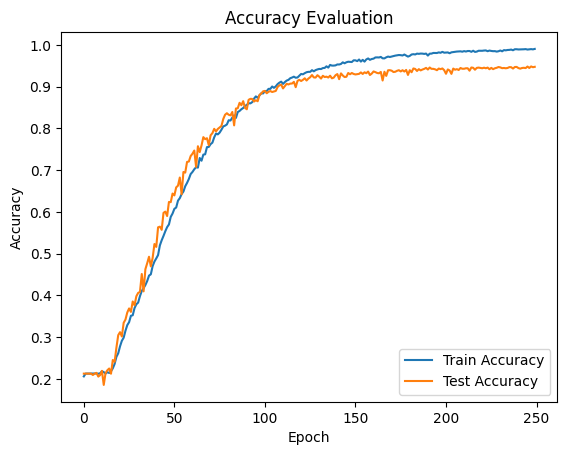

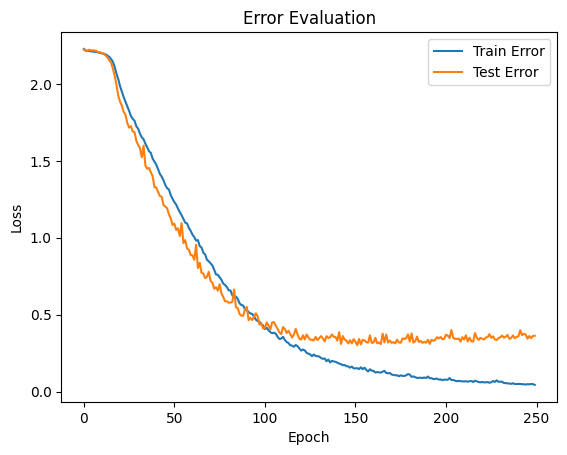

In [ ]:
plot_history(hist)